# Loading Packages and Utility Functions

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
from tqdm.notebook import tqdm
from typing import List, Tuple, Union
import time

In [11]:
def read_json(fpath: str):
    with open(fpath, "r") as f:
        data = json.load(f)
        f.close()
    return data

root_output_path = "../data/output"
file_list = [fname for fname in os.listdir(root_output_path) if fname.endswith(".json")]
file_list

['data_princeton-nlp-Sheared-LLaMA-1-3B_n500_synthid.json',
 'data_facebook-opt-1-3b_n500_pf.json',
 'data_facebook-opt-125m_n500_inverse.json',
 'data_google-gemma-3-270m_n500_gumbel.json',
 'data_facebook-opt-1-3b_n500_unwatermarked.json',
 'data_google-gemma-3-270m_n500_inverse.json',
 'data_facebook-opt-1-3b_n500_redgreen.json',
 'data_google-gemma-3-270m_n500_redgreen.json',
 'data_facebook-opt-1-3b_n500_synthid.json',
 'data_princeton-nlp-Sheared-LLaMA-1-3B_n500_pf.json',
 'data_facebook-opt-125m_n500_unwatermarked.json',
 'data_princeton-nlp-Sheared-LLaMA-1-3B_n500_gumbel.json',
 'data_facebook-opt-1-3b_n500_inverse.json',
 'data_princeton-nlp-Sheared-LLaMA-1-3B_n500_unwatermarked.json',
 'data_facebook-opt-125m_n500_gumbel.json',
 'data_facebook-opt-125m_n500_redgreen.json',
 'data_facebook-opt-1-3b_n500_gumbel.json',
 'data_princeton-nlp-Sheared-LLaMA-1-3B_n500_inverse.json',
 'data_facebook-opt-125m_n500_pf.json',
 'data_princeton-nlp-Sheared-LLaMA-1-3B_n500_redgreen.json',
 

In [12]:
# IOU is the typical metric that is tracked in these scenarios
def get_iou(intervalsA: List[Tuple[int, int]], intervalsB: List[Tuple[int, int]]):
    coordsA = set([x for start, end in intervalsA for x in range(start, end)])
    coordsB = set([x for start, end in intervalsB for x in range(start, end)])
    num = len(coordsA.intersection(coordsB))
    denom = len(coordsA.union(coordsB))
    return (num / denom)

# metric to find the symmetric differences
def get_symmetric_difference(intA, intB):
  sA, eA = intA
  sB, eB = intB
  return abs(sA - sB) + abs(eA - eB)

In [25]:
# get summary of detection methods applied for a specific data
def get_summarized_results(data, get_interval_func):
    metrics_list = []
    interval_endpoints = []
    true_intervals =  [
        (start, end) for (start, end, interval_type) in data['configuration']['intervals'] if interval_type != 'unwatermarked'
    ]

    n = 0
    for sample_index, sample_data in tqdm(list(enumerate(data["data"]))):
        pivots = sample_data["pivots"]
        n = max(n, len(pivots))
        pivots = np.array(pivots)
        pivots[np.isinf(pivots)] = pivots[~np.isinf(pivots)].max() # replace by maximum for infinite values
        est_intervals = get_interval_func(pivots)
        
        # add detected endpoints to array
        for left_end, right_end in est_intervals:
            interval_endpoints.append(left_end)
            interval_endpoints.append(right_end)

        # calculate metrics
        metric_row = {
            "sample_index": sample_index,
            "detected_intervals_count": len(est_intervals),
            "iou": get_iou(est_intervals, true_intervals)
        }
        metrics_list.append(metric_row)

    metric_df = pd.DataFrame(metrics_list)

    # print the description of the setup
    print(f"Model name: {data['configuration']['model_name']}")
    print(f"Output tokens: {data['configuration']['out_tokens']}")
    print(f"Vocab size: {data['configuration']['vocab_size']}")
    print(f"Segment types: {', '.join([interval_type for start, end, interval_type in data['configuration']['intervals']])}\n")

    # Summary 1: Frequency table of # of detected intervals
    frequency_table = metric_df['detected_intervals_count'].value_counts().reset_index()
    frequency_table.columns = ['value', 'frequency']
    frequency_table['proportion'] = frequency_table['frequency'] / frequency_table['frequency'].sum()
    print(f"Frequency Table of Detected Intervals: \n{frequency_table.sort_values(by = "frequency", ascending=False).head(5)}")

    # Summary 2: Describe the scores
    print(f"\nAdditional Metrics: \n{metric_df[['iou']].describe()}")

    # draw a histogram of detected intervals endpoints
    plt.figure(figsize=(10, 6))
    h = sns.histplot(
        data=pd.DataFrame({'endpoints': interval_endpoints}),
        x='endpoints',
        binwidth=n/100
    )
    plt.vlines(
        x=[int(a) for x in true_intervals for a in x],
        ymin=h.get_ylim()[0],
        ymax = h.get_ylim()[1],
        colors="red"
    )
    plt.title('Histogram of Detected Endpoints')
    plt.xlim(0, n)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Calculate Metrics

In [26]:
from detections import EpidemicDetector, AligatorDetector
from watermarking_func import null_distn_gumbel, null_distn_inverse, null_distn_redgreen, null_distn_synthid, null_distn_pf

In [27]:
# fname = file_list[1]
fname = "data_facebook-opt-125m_n500_gumbel.json"
data = read_json(os.path.join(root_output_path, fname))
vocab_size = data['configuration']['vocab_size']
null_distn = null_distn_gumbel

data['configuration']

{'model_name': 'facebook/opt-125m',
 'intervals': [[0, 100, 'unwatermarked'],
  [100, 200, 'gumbel'],
  [200, 325, 'unwatermarked'],
  [325, 400, 'gumbel'],
  [400, 500, 'unwatermarked']],
 'prompt_tokens': 50,
 'out_tokens': 500,
 'vocab_size': 50272,
 'initial_seed': 1234,
 'max_token_input_length': 256}

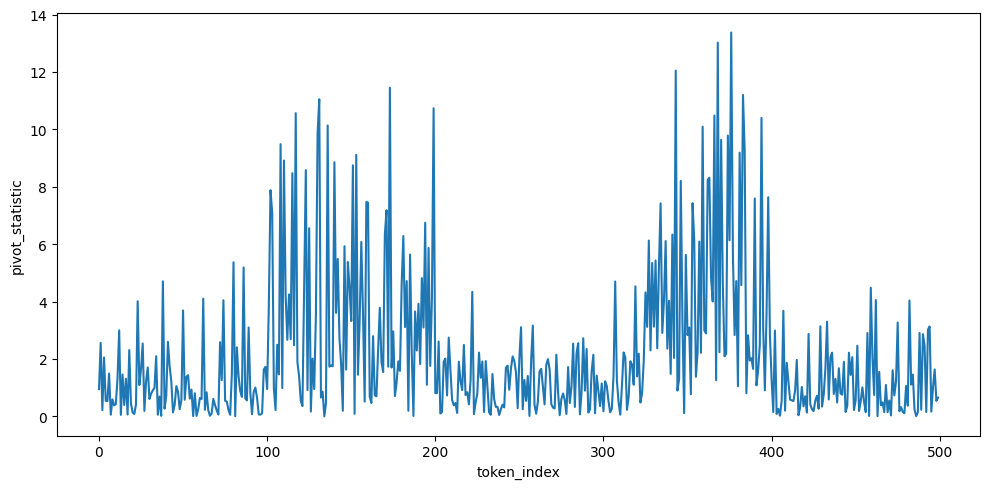

In [28]:
# sample plot for sanity testing
df = []
for sample_index, sample_data in enumerate(data["data"]):
    pivots = sample_data["pivots"]
    for token_index, pivot in enumerate(pivots):
        df.append({ "sample_index": sample_index, "token_index": token_index, "pivot_statistic": pivot})

df = pd.DataFrame(df)
agg_df = df.groupby(by = ['token_index'])[['pivot_statistic']].mean().reset_index() # plot the pivot statistic

plt.figure(figsize=(10, 5))
sns.lineplot(data=df.loc[df['sample_index'] == 1], # put agg_df in case of agg plot
             # agg_df,
             x='token_index', y='pivot_statistic')
plt.tight_layout()
plt.show()

  0%|          | 0/200 [00:00<?, ?it/s]

Model name: facebook/opt-125m
Output tokens: 500
Vocab size: 50272
Segment types: unwatermarked, gumbel, unwatermarked, gumbel, unwatermarked

Frequency Table of Detected Intervals: 
   value  frequency  proportion
0      2        197       0.985
1      1          2       0.010
2      0          1       0.005

Additional Metrics: 
              iou
count  200.000000
mean     0.830600
std      0.108811
min      0.000000
25%      0.788571
50%      0.845714
75%      0.897289
max      0.977143


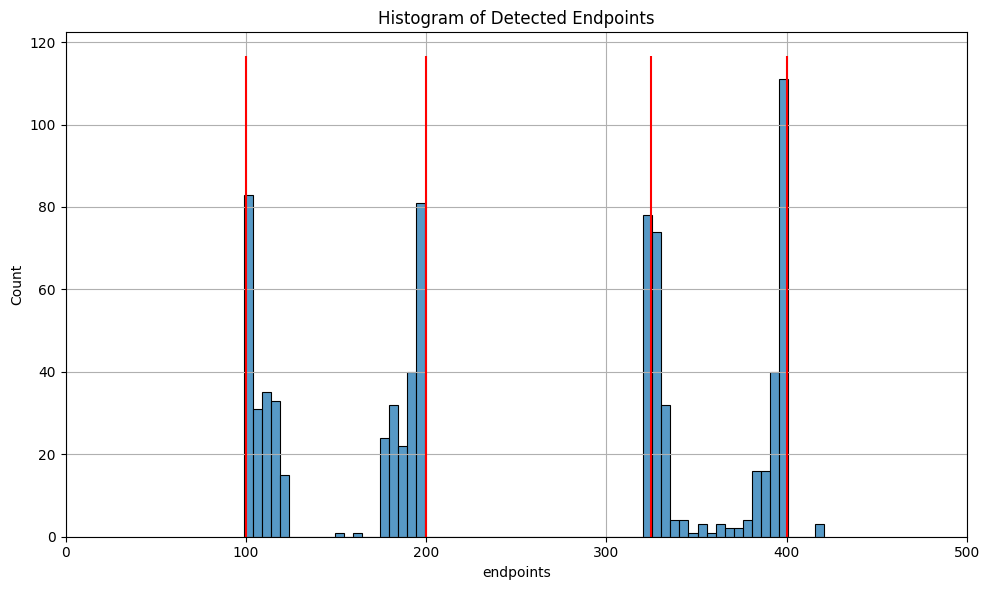

In [30]:
def get_epidemic_intervals(x):
    d = EpidemicDetector(vocab_size=vocab_size)
    return d.detect(x, null_distn=null_distn, block_size=60, c = 2)

get_summarized_results(data, get_epidemic_intervals)

  0%|          | 0/200 [00:00<?, ?it/s]

Model name: facebook/opt-125m
Output tokens: 500
Vocab size: 50272
Segment types: unwatermarked, gumbel, unwatermarked, gumbel, unwatermarked

Frequency Table of Detected Intervals: 
   value  frequency  proportion
0      4         27       0.135
1     10         22       0.110
2      5         20       0.100
3      3         19       0.095
4      6         18       0.090

Additional Metrics: 
              iou
count  200.000000
mean     0.640037
std      0.185985
min      0.000000
25%      0.530000
50%      0.674286
75%      0.782306
max      0.920455


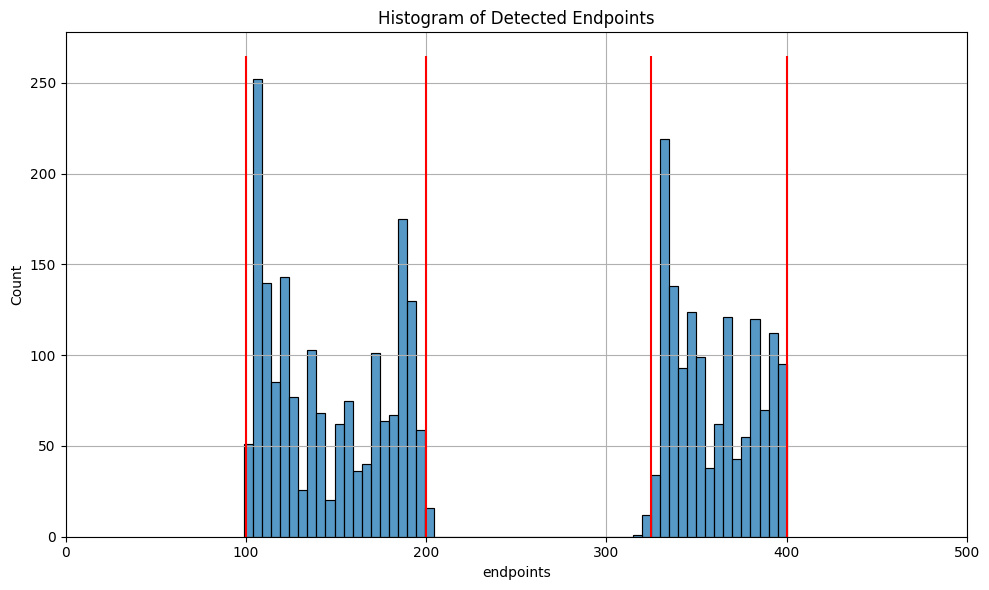

In [31]:
alpha = 0.05
null_samples = null_distn((1000, ), vocab_size)
threshold = np.quantile(null_samples, 1 - alpha)

def get_aligator_intervals(x):
    # calculate threshold based on 95\% quantile of null distribution
    d = AligatorDetector(threshold=threshold)
    return d.detect(np.array(x))

get_summarized_results(data, get_aligator_intervals)